<a href="https://colab.research.google.com/github/Paulo-vitorCS/DeepLearning/blob/main/Projeto_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Projeto 08: Regressão - Base de Carros usados (previsão do preço)

###Etapa 01: Importação das bibliotecas


In [4]:
import pandas as pd
import torch
import numpy as np
import seaborn as sns
from torch import nn, optim
import torch.nn.functional as F

###Etapa 02: Base de dados

In [5]:
np.random.seed(123)
torch.manual_seed(123)

In [6]:
base = pd.read_csv('/content/autos.csv', encoding='ISO-8859-1')  # encoding é o formato dos caracteres na base de dados

In [7]:
base.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [8]:
# Pré-processamento (limpar alguns atributos da base de dados que não serão usados)
base.shape

(371528, 20)

In [9]:
base = base.drop('dateCrawled', axis=1)
base = base.drop('dateCreated', axis=1)
base = base.drop('nrOfPictures', axis=1)
base = base.drop('postalCode', axis=1)
base = base.drop('lastSeen', axis=1)

In [10]:
# As colunas acima foram retiradas
base.shape

(371528, 15)

In [11]:
base.head()

,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
0,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN
1,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja
2,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN
3,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein
4,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein


In [12]:
# Verificar a quantidade de valores para cada categoria
base['name'].value_counts()

Ford_Fiesta                                                657
BMW_318i                                                   627
Opel_Corsa                                                 622
Volkswagen_Golf_1.4                                        603
BMW_316i                                                   523
                                                          ... 
Ford_Galaxy_TDI_Trend_X_1.9                                  1
E46_touring_450ps_alpina3.3                                  1
Audi_A3_1.6_TDI_DPF_S_line_Sportpaket                        1
Nissan_Micra_K_11.__1.0                                      1
Renault_Clio_1_2______1.Hand___72000_km__Hu_&_Au_neu_!!      1
Name: name, Length: 233531, dtype: int64

In [13]:
# Apagar coluna name
base = base.drop('name', axis=1)

In [14]:
base['seller'].value_counts()

privat        371525
gewerblich         3
Name: seller, dtype: int64

In [15]:
base = base.drop('seller', axis=1)

In [16]:
base['offerType'].value_counts()

Angebot    371516
Gesuch         12
Name: offerType, dtype: int64

In [17]:
base = base.drop('offerType', axis=1)

In [18]:
base.head()

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
0,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN
1,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja
2,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN
3,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein
4,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein


In [19]:
i1 = base.loc[base.price <= 10]  # .loc é uma função de localização

In [20]:
i1.shape  # Muitos valores abaixo de 10

(12118, 12)

In [21]:
base = base[base.price > 10]

In [22]:
base.shape  # Removido os valores menores que 10

(359410, 12)

In [23]:
i2 = base.loc[base.price > 350000]
i2.shape

(115, 12)

In [24]:
base = base[base.price < 350000]

In [25]:
base.shape  # Removido valores maiores que 350000

(359291, 12)

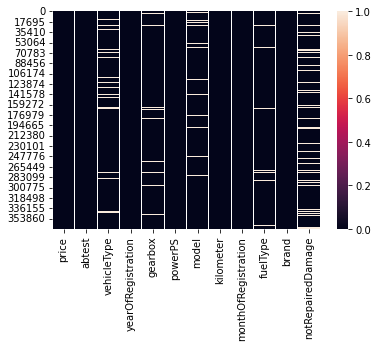

In [26]:
# Tratamento de valores nulos
sns.heatmap(base.isnull())  # Mostra as colunas e as linhas onde os valores são nulos

In [27]:
base.loc[pd.isnull(base['vehicleType'])]

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
0,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN
16,300,test,NaN,2016,NaN,60,polo,150000,0,benzin,volkswagen,NaN
22,2900,test,NaN,2018,manuell,90,meriva,150000,5,benzin,opel,nein
26,5555,control,NaN,2017,manuell,125,c4,125000,4,NaN,citroen,nein
31,899,control,NaN,2016,manuell,60,clio,150000,6,benzin,renault,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
371495,180,control,NaN,1995,NaN,0,NaN,125000,3,benzin,opel,NaN
371504,2600,control,NaN,2005,automatik,0,c_klasse,150000,9,NaN,mercedes_benz,NaN
371509,1900,test,NaN,2000,manuell,110,NaN,150000,7,NaN,volkswagen,nein
371519,5250,control,NaN,2016,automatik,150,159,150000,12,NaN,alfa_romeo,nein


In [28]:
base['vehicleType'].value_counts()  # limousine é o valor que mais aparece

limousine     93614
kleinwagen    78014
kombi         65921
bus           29699
cabrio        22509
coupe         18386
suv           14477
andere         3125
Name: vehicleType, dtype: int64

In [29]:
base.loc[pd.isnull(base['gearbox'])]

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
15,450,test,kleinwagen,1910,NaN,0,ka,5000,0,benzin,ford,NaN
16,300,test,NaN,2016,NaN,60,polo,150000,0,benzin,volkswagen,NaN
32,245,test,limousine,1994,NaN,0,golf,150000,2,benzin,volkswagen,nein
37,1500,test,NaN,2016,NaN,0,kangoo,150000,1,diesel,renault,nein
70,1200,test,coupe,2001,NaN,0,astra,150000,0,NaN,opel,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
371443,3300,control,kombi,2006,NaN,0,touran,150000,7,diesel,volkswagen,NaN
371460,3500,control,NaN,1995,NaN,0,polo,150000,0,NaN,volkswagen,NaN
371486,350,control,kleinwagen,1996,NaN,65,punto,150000,0,NaN,fiat,NaN
371495,180,control,NaN,1995,NaN,0,NaN,125000,3,benzin,opel,NaN


In [30]:
base['gearbox'].value_counts()  # manuell é o valor que mais aparece

manuell      266547
automatik     75508
Name: gearbox, dtype: int64

In [31]:
base.loc[pd.isnull(base['model'])]

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
1,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja
83,350,control,kleinwagen,1997,manuell,54,NaN,150000,3,NaN,fiat,ja
139,1450,control,limousine,1992,manuell,136,NaN,150000,0,NaN,audi,nein
156,6799,control,kleinwagen,2009,NaN,60,NaN,20000,5,benzin,volkswagen,nein
165,500,control,kleinwagen,1999,manuell,0,NaN,150000,0,benzin,renault,nein
...,...,...,...,...,...,...,...,...,...,...,...,...
371399,560,control,kleinwagen,2001,automatik,170,NaN,90000,0,benzin,fiat,ja
371476,9400,control,kombi,2007,manuell,200,NaN,150000,4,diesel,sonstige_autos,ja
371495,180,control,NaN,1995,NaN,0,NaN,125000,3,benzin,opel,NaN
371509,1900,test,NaN,2000,manuell,110,NaN,150000,7,NaN,volkswagen,nein


In [32]:
base['model'].value_counts()  # golf é o valor que mais aparece

golf               28989
andere             25560
3er                19905
polo               12604
corsa              12149
                   ...  
serie_2                8
rangerover             6
serie_3                3
discovery_sport        1
serie_1                1
Name: model, Length: 251, dtype: int64

In [33]:
base.loc[pd.isnull(base['fuelType'])]

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
9,999,test,kleinwagen,1998,manuell,101,golf,150000,0,NaN,volkswagen,NaN
13,2500,control,kombi,2004,manuell,131,passat,150000,2,NaN,volkswagen,nein
26,5555,control,NaN,2017,manuell,125,c4,125000,4,NaN,citroen,nein
36,1600,control,andere,1991,manuell,75,kadett,70000,0,NaN,opel,NaN
41,7500,control,limousine,2002,automatik,306,e_klasse,150000,4,NaN,mercedes_benz,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
371496,3850,test,cabrio,2006,manuell,108,2_reihe,125000,2,NaN,peugeot,nein
371504,2600,control,NaN,2005,automatik,0,c_klasse,150000,9,NaN,mercedes_benz,NaN
371509,1900,test,NaN,2000,manuell,110,NaN,150000,7,NaN,volkswagen,nein
371519,5250,control,NaN,2016,automatik,150,159,150000,12,NaN,alfa_romeo,nein


In [34]:
base['fuelType'].value_counts()  # benzin é o valor que mais aparece

benzin     217582
diesel     106002
lpg          5222
cng           557
hybrid        271
andere        165
elektro       101
Name: fuelType, dtype: int64

In [35]:
base.loc[pd.isnull(base['notRepairedDamage'])]

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
0,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN
2,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN
8,14500,control,bus,2014,manuell,125,c_max,30000,8,benzin,ford,NaN
9,999,test,kleinwagen,1998,manuell,101,golf,150000,0,NaN,volkswagen,NaN
12,999,control,kombi,1995,manuell,115,passat,150000,11,benzin,volkswagen,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
371507,5999,test,kombi,2005,manuell,140,a4,150000,4,diesel,audi,NaN
371514,999,control,cabrio,2000,manuell,95,megane,150000,4,benzin,renault,NaN
371515,1690,test,kombi,2004,manuell,55,fabia,150000,4,benzin,skoda,NaN
371523,2200,test,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN


In [36]:
base['notRepairedDamage'].value_counts()  # nein é o valor que mais aparece

nein    259301
ja       34004
Name: notRepairedDamage, dtype: int64

In [37]:
base.loc[pd.isnull(base['price'])]

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage


In [38]:
valores = {'vehicleType': 'limousine',
           'gearbox': 'manuell',
           'model': 'golf',
           'fuelType': 'benzin',
           'notRepairedDamage': 'nein'}

In [39]:
base = base.fillna(value = valores)

In [40]:
base.loc[pd.isnull(base['gearbox'])]  # Teste para verificar se os valores foram retirados (testar com todos os elementos)

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage


In [41]:
previsores = base.iloc[:, 1:13].values
preco_real = base.iloc[:, 0].values

In [42]:
previsores.shape

(359291, 11)

In [43]:
# One hot encoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [45]:
onehotencoder = ColumnTransformer(transformers=[('OneHot', OneHotEncoder(),
                                                [0,1,3,5,8,9,10])],
                                  remainder = 'passthrough')  # Remainder passa pelas colunas 'restantes'

In [46]:
previsores = onehotencoder.fit_transform(previsores).toarray()  # Redefinindo os previsores

In [47]:
previsores.shape  # Cada tipo de veículo será convertido em uma coluna

(359291, 316)

In [48]:
previsores[0]  # Representação do primeiro registro

array([0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 

In [49]:
type(previsores)

numpy.ndarray

In [50]:
# Conversão para o tipo do pytorch
previsores = torch.tensor(previsores, dtype = torch.float)
preco_real = torch.tensor(preco_real, dtype = torch.float).view(-1, 1)

In [52]:
type(previsores), type(preco_real)

(torch.Tensor, torch.Tensor)

In [53]:
preco_real.shape  # Agora o formato do preco é de matriz

torch.Size([359291, 1])

###Etapa 03: Construção do modelo

In [54]:
# Depois da aplicação do oneHotEncoder, chega-se a uma quantidade total de 316 atributos
# (entradas + saidas) /  2 = (316 + 1) / 2 = 158
regressor = nn.Sequential(nn.Linear(316, 158),
                          nn.ReLU(),
                          nn.Linear(158, 158),
                          nn.ReLU(),
                          nn.Linear(158, 1))

In [56]:
criterion = nn.L1Loss()  # Criterion é a função de erro, com L1Loss que equivale a métrica MAE (Mean Absolute Error)

In [57]:
optimizer = optim.Adam(regressor.parameters())

In [58]:
dataset = torch.utils.data.TensorDataset(previsores, preco_real)
train_loader = torch.utils.data.DataLoader(dataset, batch_size = 300, shuffle = True)

###Etapa 04: Treinamento do modelo

In [59]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # cuda é um tipo de GPU usada para deep learning
device

'cuda'

In [60]:
regressor.to(device)  # Tudo que for executado com regressor será enviado para o processamento da gpu

Sequential(
  (0): Linear(in_features=316, out_features=158, bias=True)
  (1): ReLU()
  (2): Linear(in_features=158, out_features=158, bias=True)
  (3): ReLU()
  (4): Linear(in_features=158, out_features=1, bias=True)
)

In [61]:
for epoch in range(100):
    running_loss = 0.
    running_mae = 0.

    for i, data in enumerate(train_loader):  # De 300 em 300 registros, definido pelo batch_size
        inputs, labels = data  # inputs = 300 atributos previsores, labels = 300 atributos reais

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # zerar os gradientes

        outputs = regressor.forward(inputs)  # valor da previsão

        mae = F.l1_loss(outputs, labels).item()  # mean absolute error 
        running_mae += mae  # Um histórico dos valores do erro

        loss = criterion(outputs, labels)  # Erro no treinamento
        loss.backward()  # Back propagation

        optimizer.step()  # Atualiza os pesos

        running_loss += loss.item()

        print('\rÉpoca {:3d} - Loop {:3d}: perda {:06.2f} - MAE {:06.2f}'.format(epoch+1,
                                                                                 i + 1,
                                                                                 len(preco_real)//300,
                                                                                 loss, mae))
    print('ÉPOCA {:3d} finalizada: perda {:0.5f} - MAE {:0.5f} '.format(epoch + 1,
                                                                        running_loss/len(train_loader),
                                                                        running_mae/len(train_loader)))

A saída de streaming foi truncada nas últimas 5000 linhas.
Época  96 - Loop 996: perda 1197.00 - MAE 2084.97
Época  96 - Loop 997: perda 1197.00 - MAE 2082.19
Época  96 - Loop 998: perda 1197.00 - MAE 1861.19
Época  96 - Loop 999: perda 1197.00 - MAE 2203.90
Época  96 - Loop 1000: perda 1197.00 - MAE 2024.69
Época  96 - Loop 1001: perda 1197.00 - MAE 1904.74
Época  96 - Loop 1002: perda 1197.00 - MAE 2075.65
Época  96 - Loop 1003: perda 1197.00 - MAE 2198.14
Época  96 - Loop 1004: perda 1197.00 - MAE 1969.98
Época  96 - Loop 1005: perda 1197.00 - MAE 2080.12
Época  96 - Loop 1006: perda 1197.00 - MAE 2170.32
Época  96 - Loop 1007: perda 1197.00 - MAE 2252.04
Época  96 - Loop 1008: perda 1197.00 - MAE 2346.66
Época  96 - Loop 1009: perda 1197.00 - MAE 2136.72
Época  96 - Loop 1010: perda 1197.00 - MAE 2543.14
Época  96 - Loop 1011: perda 1197.00 - MAE 2018.24
Época  96 - Loop 1012: perda 1197.00 - MAE 2142.99
Época  96 - Loop 1013: perda 1197.00 - MAE 2109.21
Época  96 - Loop 1014: perd

###Etapa 05: Avaliação do modelo

In [62]:
regressor.eval()  # COlocando a rede em modo de avaliação

Sequential(
  (0): Linear(in_features=316, out_features=158, bias=True)
  (1): ReLU()
  (2): Linear(in_features=158, out_features=158, bias=True)
  (3): ReLU()
  (4): Linear(in_features=158, out_features=1, bias=True)
)

In [63]:
previsoes = regressor.forward(previsores.to(device))

In [64]:
previsoes

tensor([[ 1216.9595],
        [11454.8301],
        [14137.6738],
        ...,
        [ 6095.7690],
        [ 3829.0227],
        [27774.4414]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [65]:
# Comparar com o preço real
preco_real

tensor([[  480.],
        [18300.],
        [ 9800.],
        ...,
        [ 9200.],
        [ 3400.],
        [28990.]])

In [66]:
preco_real.mean()  # média do preço real

tensor(5916.8335)

In [68]:
previsoes.mean()

tensor(5793.2778, device='cuda:0', grad_fn=<MeanBackward0>)

In [69]:
preco_real.mean() - previsoes.mean()  # Erro na média

tensor(123.5557, device='cuda:0', grad_fn=<SubBackward0>)